In [183]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (16,10)

# Data cleaning

In [184]:
data = pd.read_csv("../data/combined-resale-flat-prices.csv")

In [185]:
data.shape

(101741, 13)

In [186]:
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,mrt_station,mrt_station_approximaty
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0,YIO CHU KANG MRT STATION,823.905301
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0,ANG MO KIO MRT STATION,808.563653
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0,YIO CHU KANG MRT STATION,1204.292767
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0,BISHAN MRT STATION,1121.890344
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0,BISHAN MRT STATION,1121.890344


In [187]:
data = data.dropna()

In [188]:
X = data.drop(columns=['resale_price', 'mrt_station', 'mrt_station_approximaty'])
y = data['resale_price']

In [189]:
for c in X.columns:
    print(c, X[c].isnull().any())

month False
town False
flat_type False
block False
street_name False
storey_range False
floor_area_sqm False
flat_model False
lease_commence_date False
remaining_lease False


In [190]:
# Categorical features to numeric features

for c in ['month', 'town', 'flat_type', 'block', 'storey_range', 'flat_model']:
    X = pd.concat([X, pd.get_dummies(X[c])], axis=1)


tmp = X['remaining_lease'].str.split(" ", n = 1, expand = True)
X["years_left"] = tmp[0]
X["years_left"] = pd.to_numeric(X["years_left"])

X = X.drop(columns=['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease'])

In [191]:
X.head()

,floor_area_sqm,lease_commence_date,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,...,New Generation,Premium Apartment,Premium Apartment Loft,Premium Maisonette,Simplified,Standard,Terrace,Type S1,Type S2,years_left
0,60.0,1986,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,70
1,68.0,1981,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,65
2,69.0,1980,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,64
3,68.0,1979,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,63
4,68.0,1980,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,64


In [192]:
# Train, validation, and test split
train_split = 0.8
validation_split = 0.1
test_split = 0.1

train_X = X.iloc[:round(len(data)*train_split),:]
train_y = y.iloc[:round(len(data)*train_split)]

validation_X = X.iloc[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]
validation_y = y.iloc[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]


test_X = X.iloc[round(len(data)*train_split + len(data)*validation_split):,:]
test_y = y.iloc[round(len(data)*train_split + len(data)*validation_split):]

In [193]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((61794, 2467), (61794,), (7724, 2467), (7724,))

# Modeling

In [194]:
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Validation

In [195]:
test_predictions = model.predict(test_X)

In [196]:
mae = mean_absolute_error(y_true=test_y, y_pred=test_predictions)
mae, mae/np.mean(test_y)

(16305760252173.648, 38122960.3030727)

In [197]:
r2 = r2_score(y_true=test_y, y_pred=test_predictions)

Text(0.5, 1.0, 'Correlation between target and predictions | R^2: -2.1970649309422096e+16')

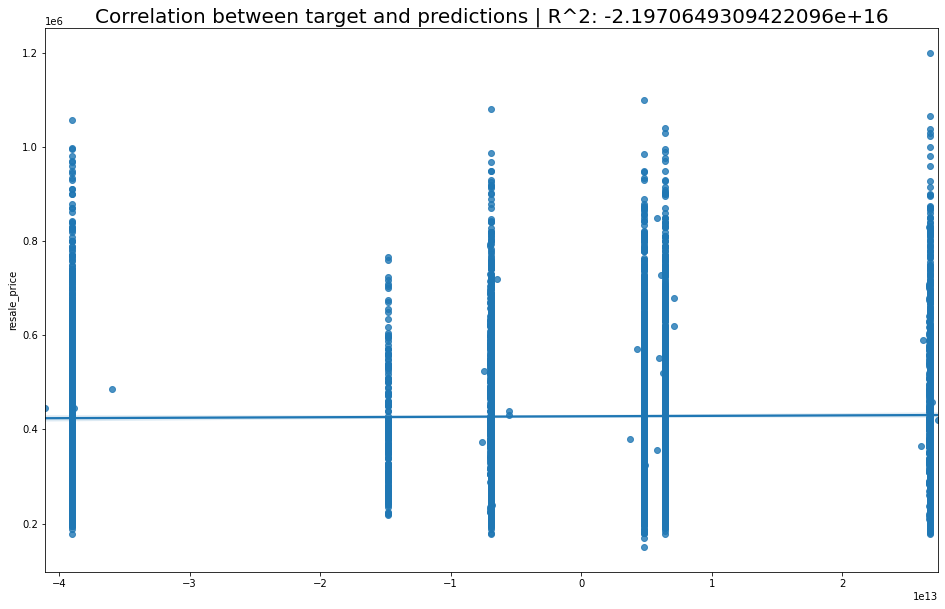

In [198]:
sns.regplot(test_predictions, test_y)
plt.title(f"Correlation between target and predictions | R^2: {r2}", fontsize=20)